## Data Prepare & Labeled

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
import pandas as pd

In [37]:
sample_df = pd.read_excel('dataset/sample_1000.xlsx')
sample_df['category'] = sample_df['情感倾向'].apply(lambda x: 2 if x == '其他' else 1 if x == 'P' else 0)

## word vectorizer

In [38]:
import jieba
import re

### baidu stopwords

In [39]:
stopwords = set(pd.read_table("stopwords/baidu_stopwords.txt",names = ["w"],sep = 'aaa',encoding = "utf-8",engine="python").w)

### jieba cut with trip \s+ to 1 \s

In [40]:
def jieba_cut(intxt):
    return [w for w in jieba.lcut(re.sub('\s+', ' ', intxt)) if w not in stopwords and len(w) > 1]

### jieba tokenize

In [41]:
txt_list = [str(row['title']) + " " + str(row['content']) for _, row in sample_df.iterrows()]
txt_after_cut_list = [jieba_cut(txt) for txt in txt_list]
target_series = sample_df['category']

In [ ]:
txt_after_cut_list

### TF-IDF Vectorizer

In [43]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim

dict = Dictionary(txt_after_cut_list)
corpus = [dict.doc2bow(line) for line in txt_after_cut_list]
model = TfidfModel(corpus) 

### Topic vectorizer LSI

In [44]:
from gensim.models import LsiModel
import numpy as np
model = LsiModel(corpus, id2word=dict, num_topics=200)
vectorized_corpus = model[corpus]
vecs = np.array([ 
    gensim.matutils.sparse2full(vectorized_corpus[i], len(vectorized_corpus[0])) for i in range(len(vectorized_corpus))
])

In [45]:
data = pd.DataFrame(vecs)
data['target'] = target_series
data

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,target
0,8.635682,23.540176,-1.306469,-0.868306,0.353932,1.611531,-6.466179,-4.871068,1.766480,-0.074037,...,-0.007179,0.116145,-0.068403,0.201193,0.270370,-0.193169,0.280830,-0.145398,-0.010755,1
1,0.378363,-0.168309,-0.097470,-0.375432,0.241658,-0.556839,0.586634,-1.242068,-0.586809,0.599930,...,0.209136,0.117902,-0.039112,-0.163391,-0.040512,0.130565,0.146207,0.047429,0.006911,1
2,2.655195,-0.371989,2.451403,1.032014,-1.260191,0.875694,-0.008770,-0.048948,-0.678931,0.309969,...,0.350611,0.205900,0.514893,-0.160896,0.877512,-0.184441,-0.985883,-0.277483,0.689515,1
3,0.735522,-0.184416,-0.097879,0.090432,-0.021385,-0.088283,0.265589,-0.276092,0.023273,-0.223188,...,-0.443746,-0.018466,0.176677,-0.378138,-0.411913,-0.047002,0.234606,0.351582,0.080690,2
4,8.216464,19.839073,-0.371077,-0.395095,-0.012315,1.600047,-4.982965,-3.690590,1.184645,0.401732,...,-0.053650,-0.115410,0.090948,0.166986,-0.355775,0.128881,0.041443,-0.269337,-0.059754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.877935,-0.980213,0.474092,0.141287,-0.176254,-0.667283,-0.581725,0.504775,1.209820,-0.999222,...,0.031210,-0.006165,-0.166891,0.422135,0.081161,-0.743036,-0.217178,-0.543159,0.128475,1
996,0.000783,-0.000258,0.001532,0.001298,-0.000613,-0.002067,0.000957,-0.000984,0.001378,0.000400,...,-0.001474,0.000967,0.000320,0.003712,-0.000518,-0.003408,0.005363,0.001241,-0.001470,1
997,4.893214,-1.050243,4.162988,2.092894,-3.239178,1.505112,-0.111714,0.492460,-1.113274,0.088050,...,-0.637140,-0.477655,0.340361,0.472562,1.112956,-0.419958,-0.052839,1.681866,-0.780205,1
998,1.643936,-0.343617,0.941932,0.371681,-0.575634,-1.372324,0.073709,-0.333058,-0.521208,-0.276699,...,-0.461999,0.530276,-0.478147,-0.378452,-0.084181,0.454888,0.185194,-0.190988,0.199212,1


## Pycaret For Classification

In [46]:
from pycaret.classification import *
clf1 = setup(data = data, target = 'target', fix_imbalance=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1000, 201)"
5,Missing Values,False
6,Numeric Features,200
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


### Compare Models

In [47]:
[best, _2, _3] = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9399,0.5375,0.6055,0.9308,0.9378,0.3890,0.4016,0.2730
qda,Quadratic Discriminant Analysis,0.9385,0.3507,0.5333,0.8957,0.9241,0.0386,0.0489,0.1160
et,Extra Trees Classifier,0.9385,0.5533,0.6045,0.9301,0.9374,0.3668,0.3797,0.2010
lightgbm,Light Gradient Boosting Machine,0.9313,0.5644,0.6009,0.9283,0.9326,0.3357,0.3494,0.6500
gbc,Gradient Boosting Classifier,0.9242,0.5399,0.6046,0.9275,0.9286,0.3535,0.3584,2.5720
ada,Ada Boost Classifier,0.7384,0.4124,0.5301,0.9087,0.8051,0.1608,0.1632,0.1890


In [48]:
print(best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


### Blend Models (Voting rule classifier)

In [49]:
blender = blend_models([best, _2, _3], method = 'hard', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9429,0.0000,0.9697,0.9697,0.9697,0.4697,0.4697
1,0.9714,0.0000,1.0000,0.9706,0.9851,0.6535,0.6966
2,0.9143,0.0000,0.3232,0.8874,0.9006,-0.0345,-0.0367
3,0.9571,0.0000,0.4444,0.9447,0.9433,0.3878,0.4899
4,0.9571,0.0000,0.5505,0.9433,0.9502,0.5522,0.5590
5,0.9429,0.0000,0.4949,0.9251,0.9331,0.4747,0.4919
6,0.9143,0.0000,0.3282,0.8613,0.8870,-0.0219,-0.0299
7,0.9571,0.0000,0.5782,0.9433,0.9502,0.6465,0.6515
8,0.9000,0.0000,0.4013,0.8866,0.8932,0.1751,0.1764


In [50]:
for e in blender.estimators:
    print(e)

('rf', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False))
('qda', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001))
('et', ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_sa

### Analyze Best Model

In [51]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

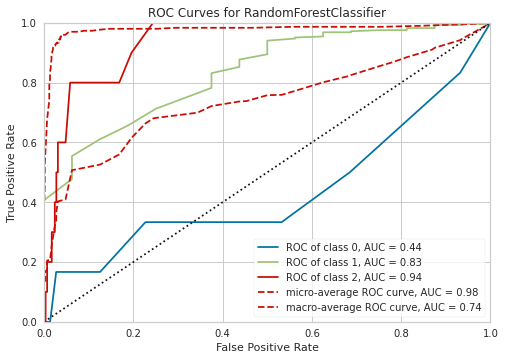

In [52]:
plot_model(best, plot = 'auc')

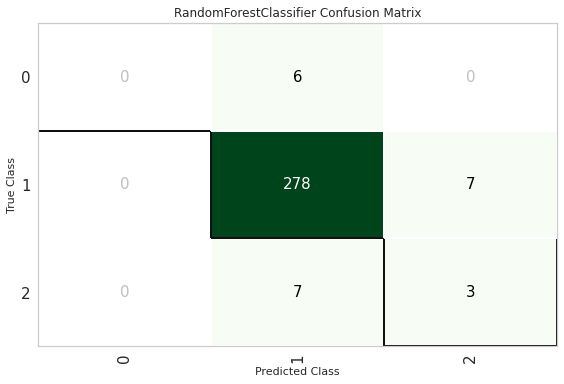

In [53]:
plot_model(best, plot = 'confusion_matrix')

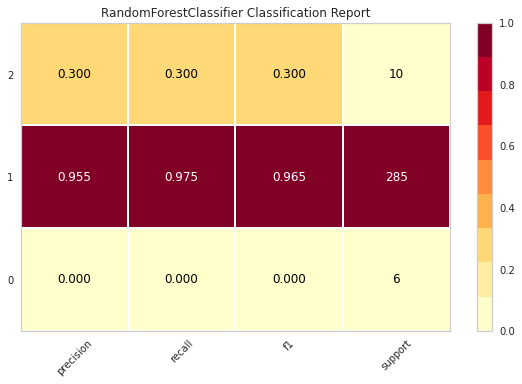

In [71]:
plot_model(best, plot = 'class_report')

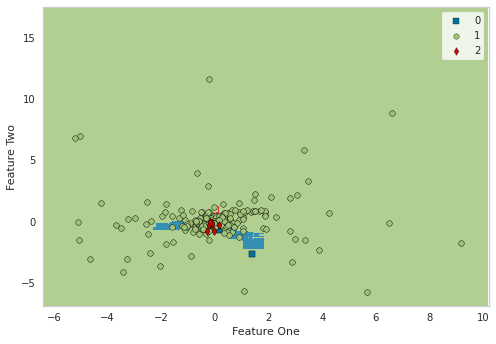

In [72]:
plot_model(best, plot='boundary')

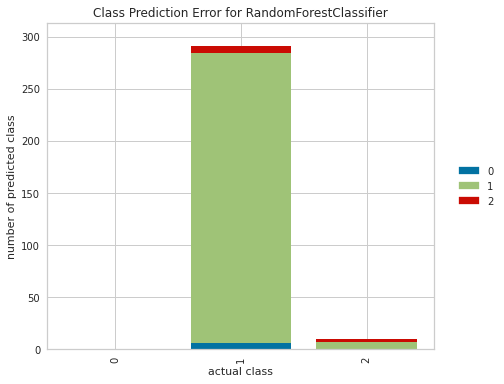

In [73]:
plot_model(best, plot = 'error')

### Predictions

In [54]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9336,0,0.4251,0.9145,0.9239,0.2043,0.2108


,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,target,Label,Score
0,2.693714,-0.776217,0.458116,1.299030,-0.868583,-0.240150,-0.270666,0.175910,0.369248,-0.212856,...,0.572438,-0.310607,0.337014,-0.565709,0.472170,-0.085712,0.261654,1,1,0.84
1,2.126817,-0.728028,0.208966,-0.239964,-0.028440,-0.361467,-0.457829,0.187777,-0.205963,-0.364093,...,0.016747,0.260497,-0.224699,0.003813,-0.340863,0.275378,-0.047205,1,1,0.89
2,3.758232,-1.273082,0.481265,-0.680190,-0.193690,0.615118,-0.626095,0.509913,-0.301125,0.129073,...,-0.036754,-0.108858,0.499141,-0.609488,0.020198,-0.266995,-0.010672,1,1,0.94
3,1.380056,-0.290279,0.713374,0.532077,-0.490405,0.016066,0.180245,-0.274726,-0.047489,0.243724,...,-0.218317,0.258775,-0.014715,0.097919,0.156099,-0.093846,0.046794,1,1,0.85
4,0.113704,0.004214,0.174635,0.076126,-0.147121,0.066405,0.109786,-0.008207,-0.087677,0.020832,...,-0.081686,0.015042,-0.088821,-0.001384,-0.022565,0.102726,-0.012185,1,1,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,1.159967,-0.336122,0.391891,0.059398,-0.200746,-1.573385,0.118697,-0.372775,1.703677,-0.728279,...,0.024533,0.076449,-0.205355,0.199923,0.068474,0.082723,0.332777,1,1,0.91
297,3.753275,-1.135441,0.903811,0.066185,-0.657123,-0.188721,-0.083897,-0.286133,0.318328,-0.745214,...,0.514337,-0.099305,0.441861,0.764218,1.007924,0.048450,-0.469287,1,1,0.88
298,4.595261,-1.525781,1.190295,-2.110436,-0.915215,-7.655050,-7.079650,4.659654,-4.056973,-1.842412,...,-0.425568,1.224368,-0.227950,-0.621593,-0.893029,-0.187552,0.460215,1,1,0.93
299,1.719467,-0.667819,-0.410895,-1.209150,0.783571,-1.484778,1.976845,-3.900498,-1.876196,1.769409,...,0.094169,0.288179,0.139875,-0.057785,-0.190521,-0.080429,-0.062238,1,1,0.95


In [55]:
predictions = predict_model(best, data=data)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9800,0.9812,0.7940,0.9801,0.9791,0.8156,0.8170


,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,target,Label,Score
0,8.635682,23.540176,-1.306469,-0.868306,0.353932,1.611531,-6.466179,-4.871068,1.766480,-0.074037,...,-0.068403,0.201193,0.270370,-0.193169,0.280830,-0.145398,-0.010755,1,1,0.95
1,0.378363,-0.168309,-0.097470,-0.375432,0.241658,-0.556839,0.586634,-1.242068,-0.586809,0.599930,...,-0.039112,-0.163391,-0.040512,0.130565,0.146207,0.047429,0.006911,1,1,0.95
2,2.655195,-0.371989,2.451403,1.032014,-1.260191,0.875694,-0.008770,-0.048948,-0.678931,0.309969,...,0.514893,-0.160896,0.877512,-0.184441,-0.985883,-0.277483,0.689515,1,1,0.91
3,0.735522,-0.184416,-0.097879,0.090432,-0.021385,-0.088283,0.265589,-0.276092,0.023273,-0.223188,...,0.176677,-0.378138,-0.411913,-0.047002,0.234606,0.351582,0.080690,2,2,0.91
4,8.216464,19.839073,-0.371077,-0.395095,-0.012315,1.600047,-4.982965,-3.690590,1.184645,0.401732,...,0.090948,0.166986,-0.355775,0.128881,0.041443,-0.269337,-0.059754,1,1,0.87


In [56]:
predictions = predict_model(best, data=data, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9800,0.9812,0.7940,0.9801,0.9791,0.8156,0.8170


,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,target,Label,Score_0,Score_1,Score_2
0,8.635682,23.540176,-1.306469,-0.868306,0.353932,1.611531,-6.466179,-4.871068,1.766480,-0.074037,...,0.270370,-0.193169,0.280830,-0.145398,-0.010755,1,1,0.01,0.95,0.04
1,0.378363,-0.168309,-0.097470,-0.375432,0.241658,-0.556839,0.586634,-1.242068,-0.586809,0.599930,...,-0.040512,0.130565,0.146207,0.047429,0.006911,1,1,0.00,0.95,0.05
2,2.655195,-0.371989,2.451403,1.032014,-1.260191,0.875694,-0.008770,-0.048948,-0.678931,0.309969,...,0.877512,-0.184441,-0.985883,-0.277483,0.689515,1,1,0.05,0.91,0.04
3,0.735522,-0.184416,-0.097879,0.090432,-0.021385,-0.088283,0.265589,-0.276092,0.023273,-0.223188,...,-0.411913,-0.047002,0.234606,0.351582,0.080690,2,2,0.01,0.08,0.91
4,8.216464,19.839073,-0.371077,-0.395095,-0.012315,1.600047,-4.982965,-3.690590,1.184645,0.401732,...,-0.355775,0.128881,0.041443,-0.269337,-0.059754,1,1,0.02,0.87,0.11


### Tune Model

In [57]:
tuned_best = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9429,0.0000,0.9697,0.9697,0.9697,0.4697,0.4697
1,0.9571,0.0000,0.9697,0.9846,0.9771,0.6441,0.6486
2,0.9000,0.7276,0.3182,0.8866,0.8932,-0.0448,-0.0453
3,0.9571,0.9263,0.5505,0.9433,0.9502,0.5522,0.5590
4,0.9286,0.7808,0.5404,0.9310,0.9283,0.4118,0.4159
5,0.9143,0.6972,0.4846,0.9086,0.9111,0.3588,0.3593
6,0.8571,0.8630,0.3077,0.8571,0.8571,-0.0687,-0.0688
7,0.9571,0.9204,0.5782,0.9433,0.9502,0.6465,0.6515
8,0.8571,0.7042,0.3859,0.8778,0.8664,0.0991,0.1011


In [60]:
print(tuned_best)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


### After tuned

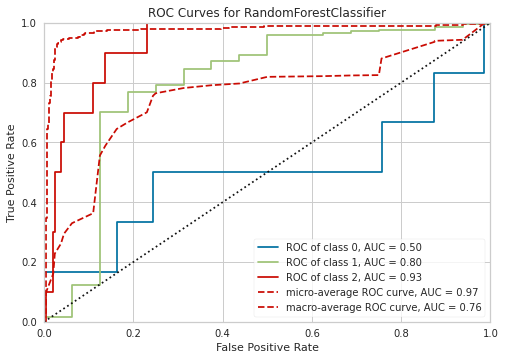

In [62]:
plot_model(tuned_best, plot = 'auc')

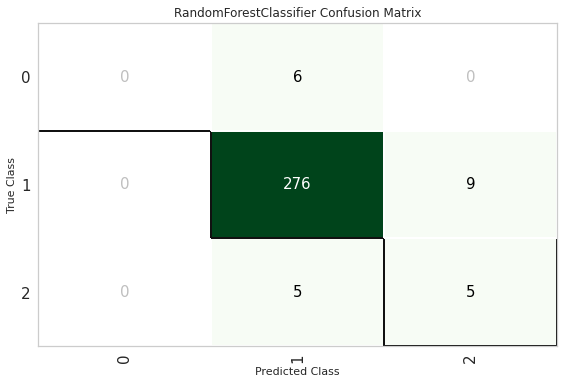

In [61]:
plot_model(tuned_best, plot = 'confusion_matrix')

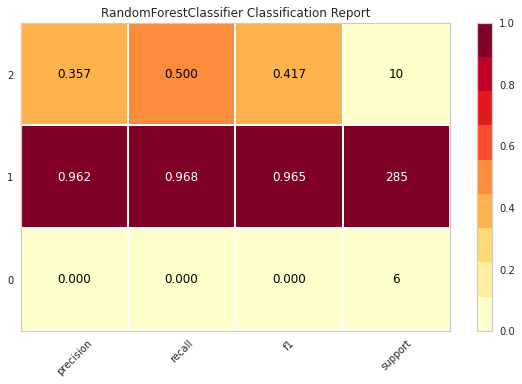

In [70]:
plot_model(tuned_best, plot = 'class_report')

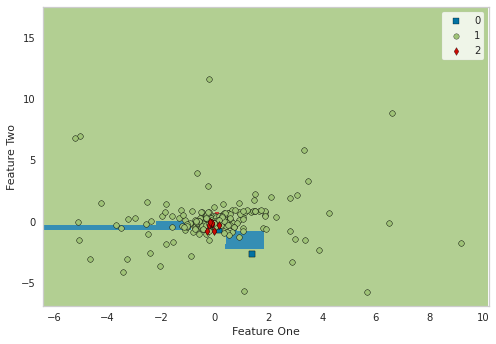

In [74]:
plot_model(tuned_best, plot='boundary')

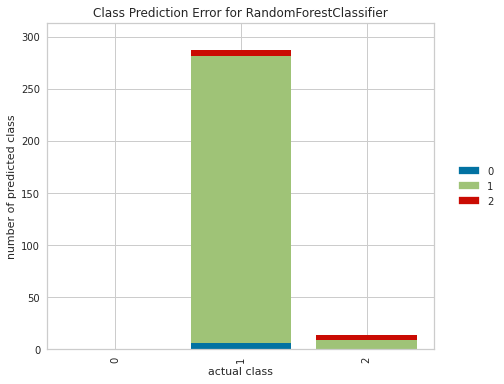

In [75]:
plot_model(tuned_best, plot='error')

In [63]:
predictions = predict_model(tuned_best, data=data)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9580,0.9528,0.7997,0.9688,0.9608,0.6810,0.6898


,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,target,Label,Score
0,8.635682,23.540176,-1.306469,-0.868306,0.353932,1.611531,-6.466179,-4.871068,1.766480,-0.074037,...,-0.068403,0.201193,0.270370,-0.193169,0.280830,-0.145398,-0.010755,1,1,0.8674
1,0.378363,-0.168309,-0.097470,-0.375432,0.241658,-0.556839,0.586634,-1.242068,-0.586809,0.599930,...,-0.039112,-0.163391,-0.040512,0.130565,0.146207,0.047429,0.006911,1,1,0.7867
2,2.655195,-0.371989,2.451403,1.032014,-1.260191,0.875694,-0.008770,-0.048948,-0.678931,0.309969,...,0.514893,-0.160896,0.877512,-0.184441,-0.985883,-0.277483,0.689515,1,1,0.8367
3,0.735522,-0.184416,-0.097879,0.090432,-0.021385,-0.088283,0.265589,-0.276092,0.023273,-0.223188,...,0.176677,-0.378138,-0.411913,-0.047002,0.234606,0.351582,0.080690,2,2,0.7850
4,8.216464,19.839073,-0.371077,-0.395095,-0.012315,1.600047,-4.982965,-3.690590,1.184645,0.401732,...,0.090948,0.166986,-0.355775,0.128881,0.041443,-0.269337,-0.059754,1,1,0.8010


### calibrate_model

In [58]:
calibrated_best = calibrate_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9286,0.0000,0.9697,0.9552,0.9624,0.2489,0.2518
1,0.9714,0.0000,1.0000,0.9706,0.9851,0.6535,0.6966
2,0.9286,0.6046,0.3283,0.8882,0.9079,-0.0204,-0.0258
3,0.9429,0.9215,0.3333,0.8890,0.9151,0.0000,0.0000
4,0.9571,0.7443,0.5505,0.9433,0.9502,0.5522,0.5590
5,0.9429,0.6361,0.4949,0.9251,0.9331,0.4747,0.4919
6,0.9143,0.8528,0.3282,0.8613,0.8870,-0.0219,-0.0299
7,0.9571,0.8627,0.5782,0.9433,0.9502,0.6465,0.6515
8,0.9000,0.6798,0.4013,0.8866,0.8932,0.1751,0.1764


In [64]:
print(calibrated_best)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                               

### After calibrate

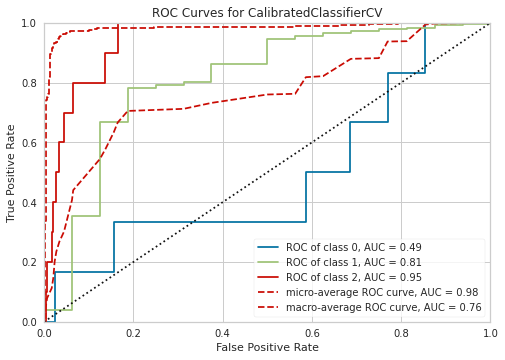

In [67]:
plot_model(calibrated_best, plot = 'auc')

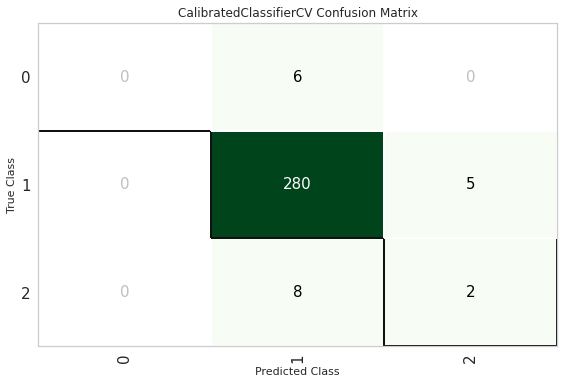

In [68]:
plot_model(calibrated_best, plot = 'confusion_matrix')

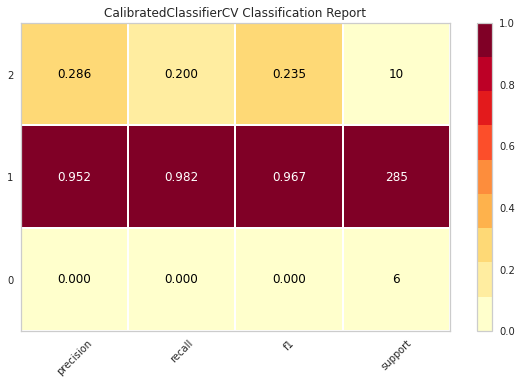

In [77]:
plot_model(calibrated_best, plot='class_report')

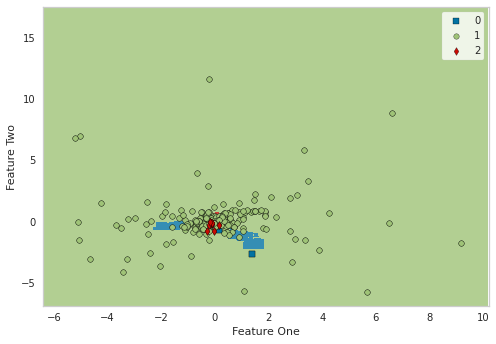

In [78]:
plot_model(calibrated_best, plot='boundary')

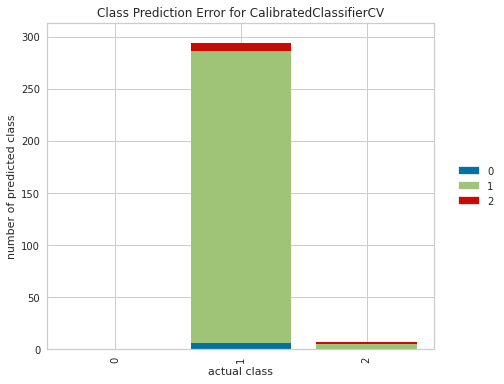

In [79]:
plot_model(calibrated_best, plot='error')

In [69]:
predictions = predict_model(calibrated_best, data=data)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9810,0.9717,0.7876,0.9808,0.9799,0.8204,0.8234


,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,target,Label,Score
0,8.635682,23.540176,-1.306469,-0.868306,0.353932,1.611531,-6.466179,-4.871068,1.766480,-0.074037,...,-0.068403,0.201193,0.270370,-0.193169,0.280830,-0.145398,-0.010755,1,1,0.9920
1,0.378363,-0.168309,-0.097470,-0.375432,0.241658,-0.556839,0.586634,-1.242068,-0.586809,0.599930,...,-0.039112,-0.163391,-0.040512,0.130565,0.146207,0.047429,0.006911,1,1,0.9934
2,2.655195,-0.371989,2.451403,1.032014,-1.260191,0.875694,-0.008770,-0.048948,-0.678931,0.309969,...,0.514893,-0.160896,0.877512,-0.184441,-0.985883,-0.277483,0.689515,1,1,0.9931
3,0.735522,-0.184416,-0.097879,0.090432,-0.021385,-0.088283,0.265589,-0.276092,0.023273,-0.223188,...,0.176677,-0.378138,-0.411913,-0.047002,0.234606,0.351582,0.080690,2,2,0.9782
4,8.216464,19.839073,-0.371077,-0.395095,-0.012315,1.600047,-4.982965,-3.690590,1.184645,0.401732,...,0.090948,0.166986,-0.355775,0.128881,0.041443,-0.269337,-0.059754,1,1,0.9905
